# Airfoil Self-Noise Prediction Project**Authors : Marion RIQUELME, Kélian RONDEAU, Jonathan VERDIER**


## 1. Objective
The goal of this project is to predict the **sound pressure level (dB)** generated by an airfoil based on aerodynamic and geometric parameters. This is a regression problem crucial for aeroacoustic design.

## 2. Dataset
The dataset comprises different size NACA 0012 airfoils tested at various wind tunnel speeds and angles of attack.
**Target Variable:** Sound pressure level (dB).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


## 3. Data Loading and Preprocessing
We load the dataset and perform a standard scaling to ensure all features contribute equally to the model, especially for linear regression.
Our dataset comes from aeroacoustic experiments. Its purpose is to measure the noisegenerated by the profile of an objet based on : 
- frequency (Hz)
- angle of incidence (deg)
- wind chord (m)
- air speed (m/s)
- boundary layer displacement thickness (m)

In [2]:
#Load dataset
df = pd.read_csv("airfoil_self_noise.csv")

#Pre-visualization of dataset
df.head(5)

,Frequency_Hz,Angle_of_attack_deg,Chord_length_m,Free_stream_velocity_m_s,Suction_side_disp_thickness_m,Sound_pressure_level_dB
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
print("Shape : ", df.shape,"\n")
print(df.info(),"\n")
print(df.isnull().sum())

Shape :  (1503, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Frequency_Hz                   1503 non-null   int64  
 1   Angle_of_attack_deg            1503 non-null   float64
 2   Chord_length_m                 1503 non-null   float64
 3   Free_stream_velocity_m_s       1503 non-null   float64
 4   Suction_side_disp_thickness_m  1503 non-null   float64
 5   Sound_pressure_level_dB        1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None 

Frequency_Hz                     0
Angle_of_attack_deg              0
Chord_length_m                   0
Free_stream_velocity_m_s         0
Suction_side_disp_thickness_m    0
Sound_pressure_level_dB          0
dtype: int64


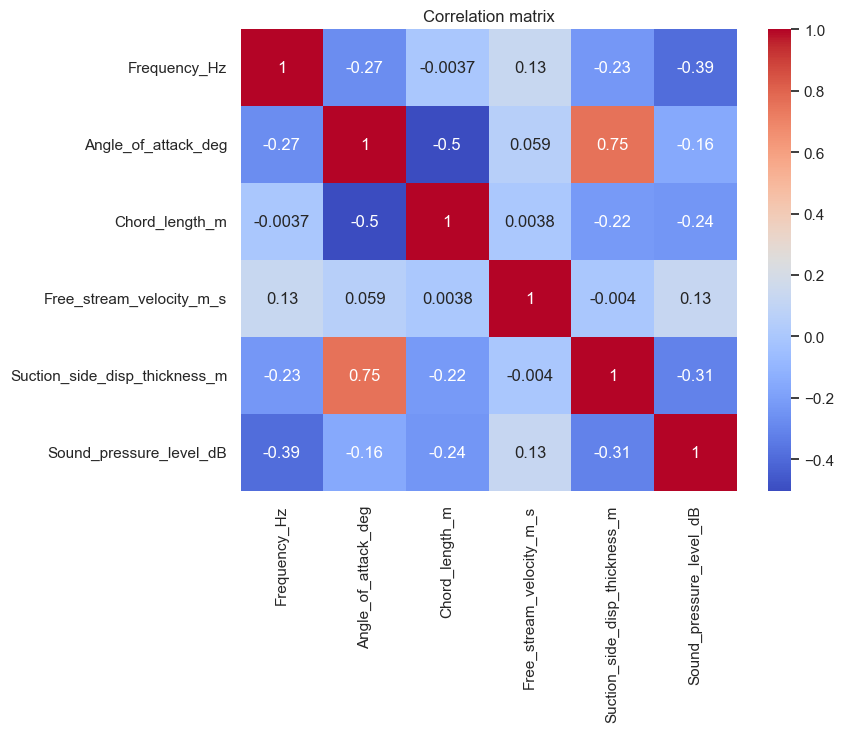

In [4]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

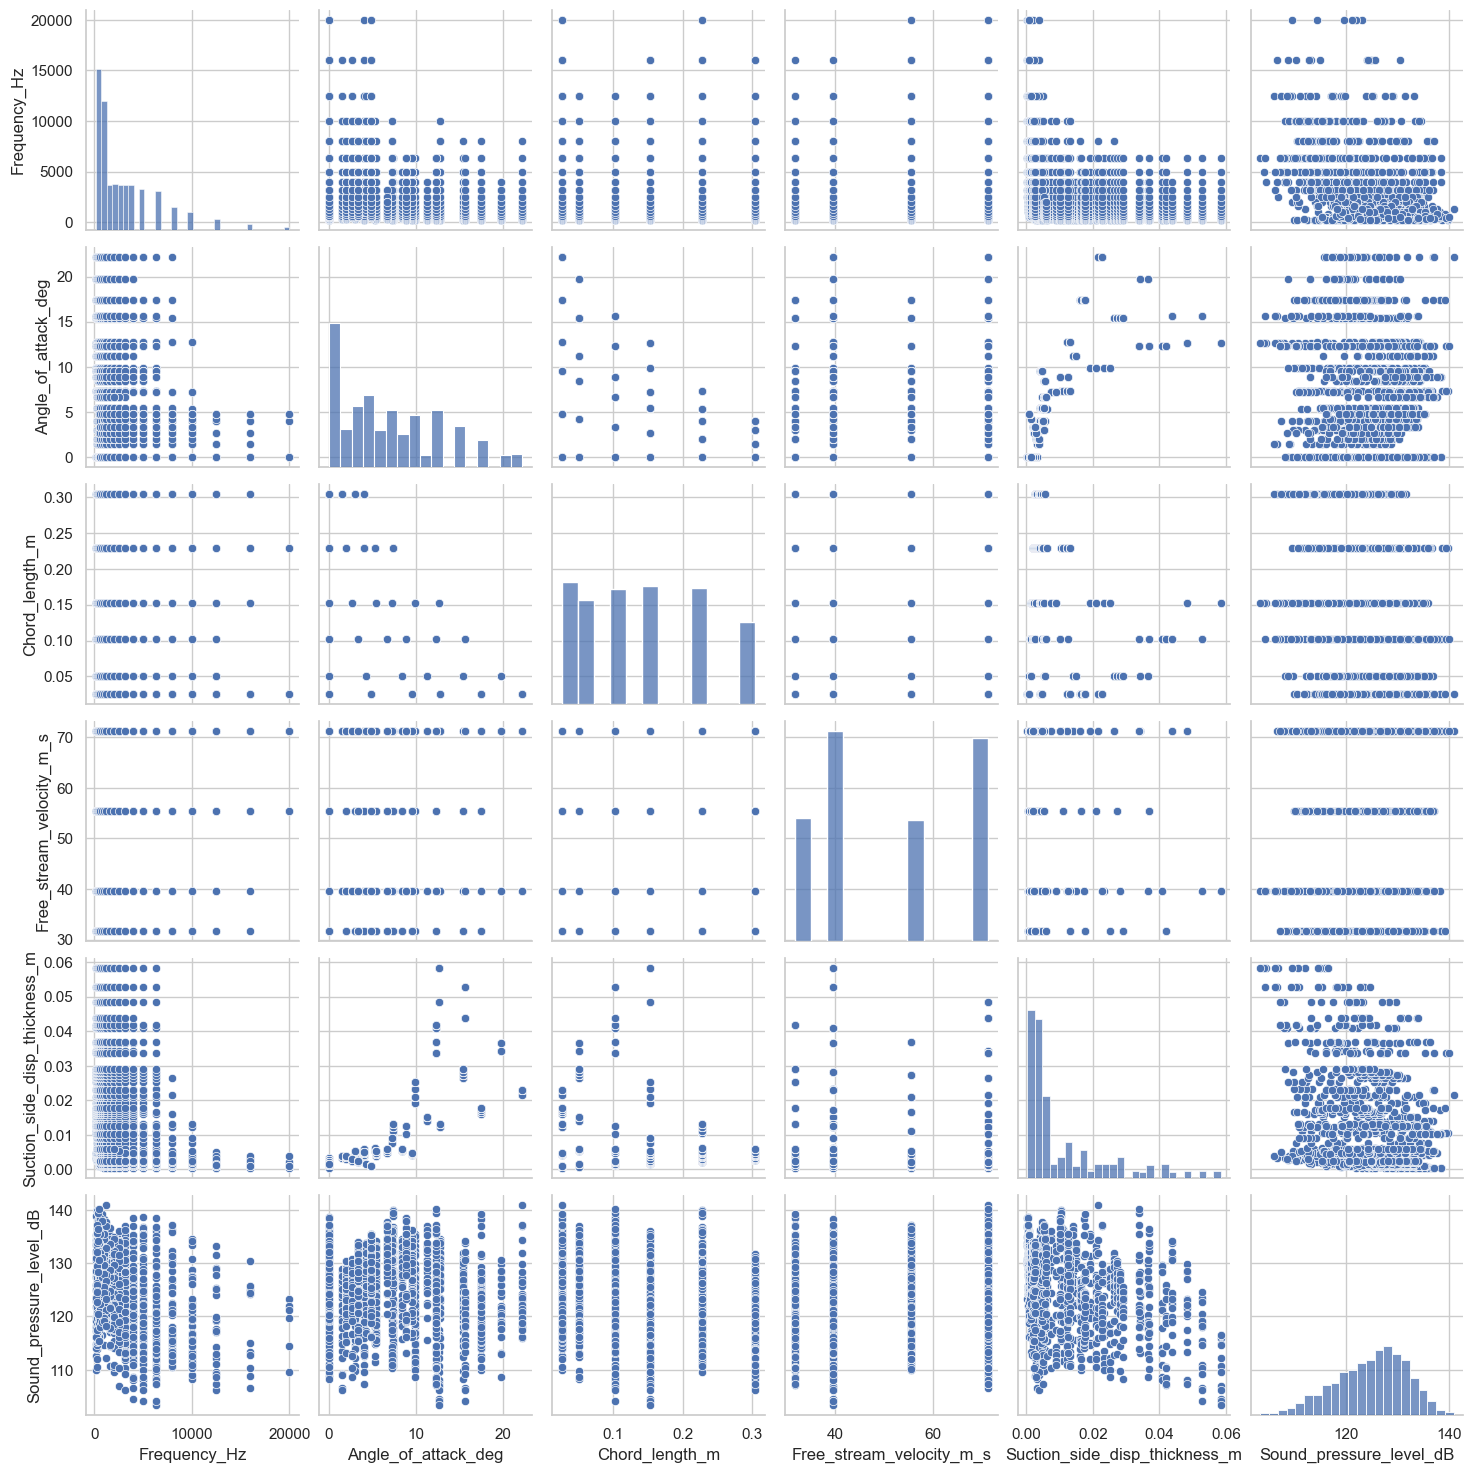

In [5]:
sns.pairplot(df)
plt.show()

This represents all the relations between the numerical variables of the dataset.
Each case shows a scatterplot between 2 variables so we can see their correlation
The main diagonale shows the histogram of each variable
This function of sns.paiplot() is useful to see the linear relations, the outliers et tendencies.

All of this shows that the sound pressure level (our target variable) is manly influenced by frequency and suction side disp thickness. They are negatively correlated : at high frequency and thick layer, the sound pressure level tends to decrease.
But none of those variables has a big correlation with sound so it suggests that it's a multifactoriel and non-linear phenomenon

The angle of attack and the thickness are very correlated (0,75), so it suggests that a bigger angle will lead  to a layer more thick.
We will try the linear regression but we think it's not gonna be the most precise one and we'll have to try an other model.

In [6]:
#Feature selection X and Target y
X = df.drop(columns=['Sound_pressure_level_dB'])
y = df['Sound_pressure_level_dB']

#Train-Test Split (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (1202, 5)
Test set shape: (301, 5)


## 4. Baseline Model: Linear Regression
We start with a simple Linear Regression to establish a baseline performance.

#### 4.1 Trying lr model

In [7]:
#Initialize and train
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

#Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

#Evaluation
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"     Linear Regression Results :    ")
print(f"RMSE: {rmse_lr:.2f} dB")
print(f"R²: {r2_lr:.3f}")

     Linear Regression Results :    
RMSE: 4.70 dB
R²: 0.558


#### Interpretation :
For the RMSE : The model’s predictions deviate from the actual measured sound pressure levels by about 4.7 decibels. In practical terms, this indicates moderate accuracy (the model captures general trends but not fine details).

For the R² : The model explains about 56% of the variance in the measured SPL values. This suggests that more than half of the variation is captured by the model, but a substantial portion (around 44%) remains unexplained.

#### Scientific Visualization: Real vs Predicted

*--> Linear regression visualization : Scatter plot comparing true sound pressure levels to predicted values*

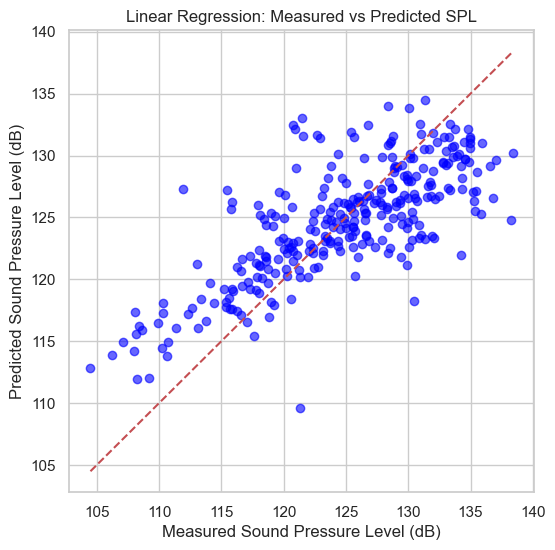

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Measured Sound Pressure Level (dB)")
plt.ylabel("Predicted Sound Pressure Level (dB)")
plt.title("Linear Regression: Measured vs Predicted SPL")
plt.grid(True)
plt.show()

#### Interpretation of model vizualisation :
The scatter plot shows a clear positive correlation between measured and predicted SPL values, meaning the model generally predicts correctly (higher measured SPL corresponds to higher predicted SPL). However, the points are scattered around the red 1:1 line, indicating some prediction errors. The spread widens at higher SPL levels, suggesting that the model’s accuracy decreases for louder cases and that the relationship may not be perfectly linear. Overall, the linear regression captures the main trend but misses some variability in the data.

*--> Residuals = difference between measured and predicted SPL*

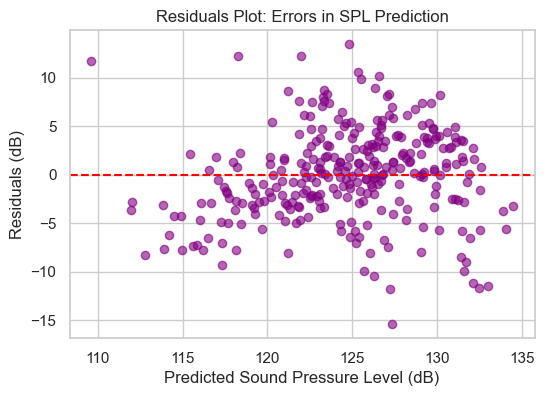

In [9]:
residuals = y_test - y_pred_lr
plt.figure(figsize=(6,4))
plt.scatter(y_pred_lr, residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sound Pressure Level (dB)")
plt.ylabel("Residuals (dB)")
plt.title("Residuals Plot: Errors in SPL Prediction")
plt.grid(True)
plt.show()

#### Interpretation of residuals vizualisation :
Most residuals are scattered around zero, indicating the model captures the general trend.

However, there is some spread and slight pattern at higher predicted SPL values, suggesting that non-linear effects or interactions between features may not be fully captured by the linear model.

Overall, the linear regression provides a reasonable baseline, but more complex models might improve accuracy.

#### 4.2 Formalisation of the problem

The Airfoil Self-Noise data comes from wind tunnel experiments on aerodynamic profiles.
The objective is to predict the acoustic pressure level (in dB) generated by an aerodynamic profile, based on parameters such as frequency, angle of attack, chord length, free stream velocity, and boundary layer thickness.
This is a supervised regression problem, because the input variables are continuous physical measurements.The target variable is also continuous (sound pressure level).
 
By building a predictive model, we can estimate the expected noise level for given aerodynamic conditions.
This model is useful for aeroacoustic design, as it allows engineers to reduce noise emissions and improve the performance of aerodynamic profiles without having to carry out costly experiments.

## Conclusion

We have seen that linear regression does not allow for very good prediction, as we have seen with R^2 and RMSE. This is due to non-linearity.
Next, we can take a more complex model such as Random Forest Regressor. It will allow us to capture non-linear relationships and interactions between variables. Thus, we hope to have a more reliable prediction.

## 5. Advanced Model: Random Forest Regressor
To capture non-linear relationships observed in the data, we implement a Random Forest model (Bagging method).

### 5.1 Feature Importance
We analyze which physical parameters have the most impact on noise generation.

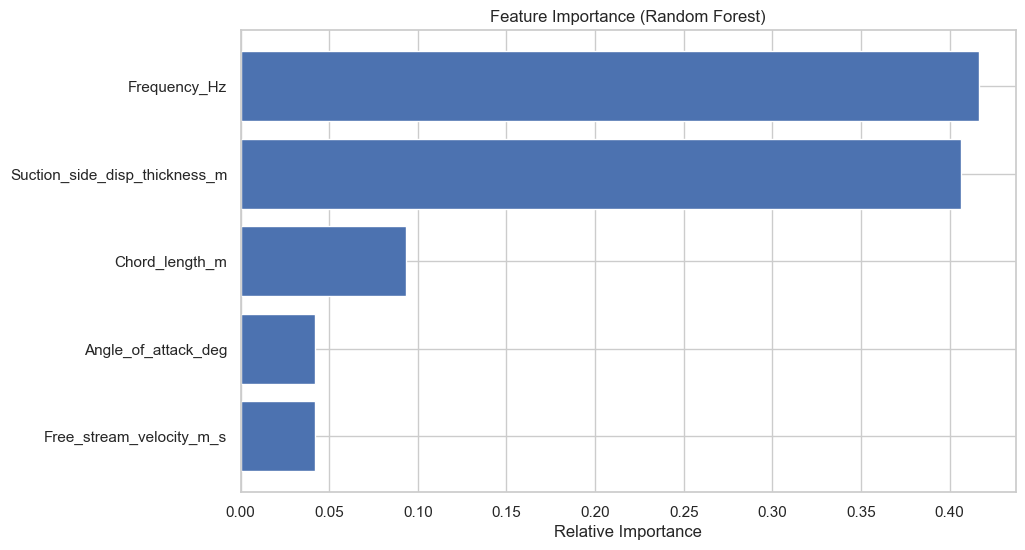

In [10]:
# Train Random Forest with default parameters
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train_scaled, y_train)

# Feature Importance Visualization
importances = rf_default.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance (Random Forest)')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 5.2 Hyperparameter Tuning (Grid Search)
We apply Grid Search to find the optimal configuration for the Random Forest model to prevent overfitting.

In [11]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Run Grid Search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_

# Evaluation of Optimized Model
y_pred_rf = best_rf.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"--> Optimized Random Forest Results")
print(f"RMSE: {rmse_rf:.2f} dB")
print(f"R²: {r2_rf:.3f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
--> Optimized Random Forest Results
RMSE: 1.82 dB
R²: 0.934


## 6. Ensemble Method: Stacking
We combine the Linear Regression (for global trend) and the optimized Random Forest (for local complexities) using a Stacking Regressor with a Ridge meta-learner.

In [12]:
estimators = [
    ('lr', LinearRegression()),
    ('rf', best_rf)
]

#Initialize Stacking Regressor
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

#Train
stacking_model.fit(X_train_scaled, y_train)

#Predict & Evaluate
y_pred_stack = stacking_model.predict(X_test_scaled)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print(f"--> Stacking Model Results")
print(f"RMSE: {rmse_stack:.2f} dB")
print(f"R²: {r2_stack:.3f}")

--> Stacking Model Results
RMSE: 1.77 dB
R²: 0.937


## 7. Final Comparison and Conclusion
We compare the performance of all implemented models.

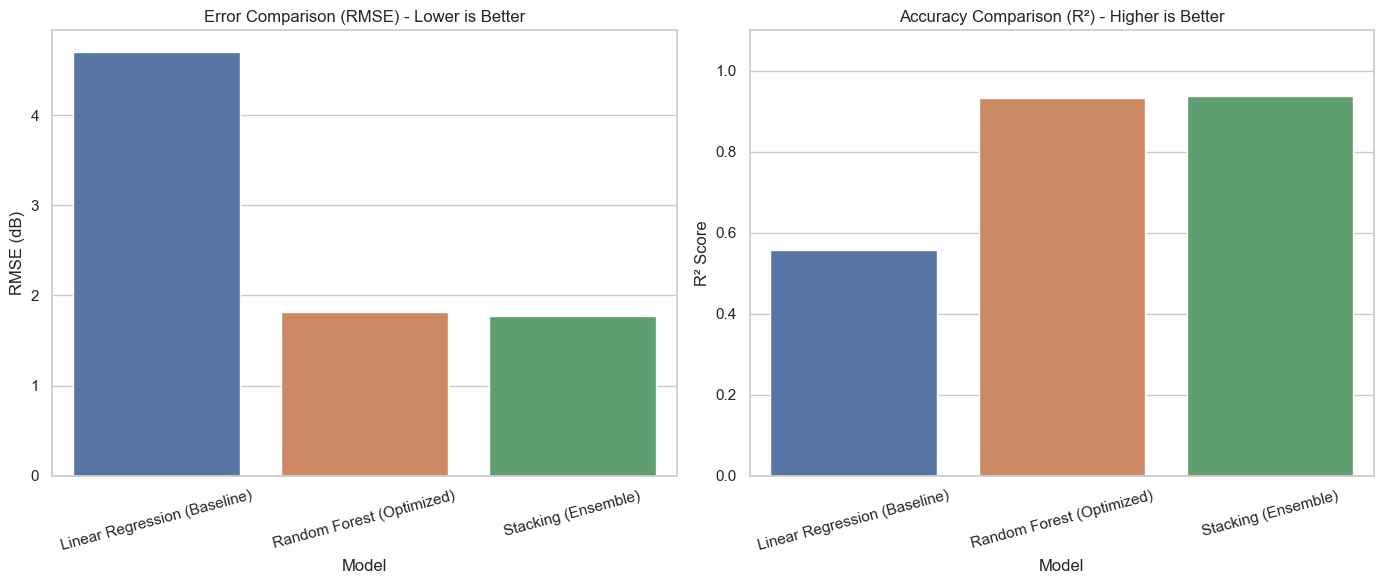

,Model,RMSE,R2
0,Linear Regression (Baseline),4.704109,0.558298
1,Random Forest (Optimized),1.820872,0.933819
2,Stacking (Ensemble),1.773914,0.937188


In [13]:
#Create Results DataFrame
results_data = {
    'Model': ['Linear Regression (Baseline)', 'Random Forest (Optimized)', 'Stacking (Ensemble)'],
    'RMSE': [rmse_lr, rmse_rf, rmse_stack],
    'R2': [r2_lr, r2_rf, r2_stack]
}

df_results = pd.DataFrame(results_data)

#Visualization
plt.figure(figsize=(14, 6))

#RMSE Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', hue='Model', data=df_results)
plt.title('Error Comparison (RMSE) - Lower is Better')
plt.ylabel('RMSE (dB)')
plt.xticks(rotation=15)

#R2 Plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', hue='Model', data=df_results)
plt.title('Accuracy Comparison (R²) - Higher is Better')
plt.ylabel('R² Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

#Final Metrics Display
display(df_results.sort_values(by='R2'))

### Conclusion
The **Stacking Regressor** is the best performing model. By combining Linear Regression and Random Forest, we successfully reduced the RMSE from **4.70 dB** (baseline) to **1.77 dB**. The model explains **93.7%** of the variance in sound pressure levels, providing a robust tool for aeroacoustic prediction.

# **Now we want to see how reacts our dataset when we drop the feature : Suction_side_disp_thickness_m**
Based on the initial project assessment, we saw a clear benefit in dropping the Suction_side_disp_thickness_m column. We chose this one because :
- The variable has a strong positive correlation (r = 0.75) with the Angle of attack (Angle_of_attack_deg). In regression models, this indicates redundancy; the two variables provide largely the same information, and removing one can simplify the model without a major loss in accuracy.
- The angle of attack is typically a design parameter set by engineers, whereas the displacement thickness is a fluid response parameter (a result of the flow). Direct design inputs are preferred.

In [14]:
df_2 = pd.read_csv("airfoil_self_noise.csv")
df_2.drop(columns=['Suction_side_disp_thickness_m'], inplace=True)
df_2.head(5)

,Frequency_Hz,Angle_of_attack_deg,Chord_length_m,Free_stream_velocity_m_s,Sound_pressure_level_dB
0,800,0.0,0.3048,71.3,126.201
1,1000,0.0,0.3048,71.3,125.201
2,1250,0.0,0.3048,71.3,125.951
3,1600,0.0,0.3048,71.3,127.591
4,2000,0.0,0.3048,71.3,127.461


In [15]:
X_V2 = df_2.drop(columns=['Sound_pressure_level_dB'])
y_V2 = df_2['Sound_pressure_level_dB']


X_train_V2, X_test_V2, y_train_V2, y_test_V2 = train_test_split(X_V2, y_V2, test_size=0.2, random_state=42)

scaler_V2 = StandardScaler()
X_train_scaled_V2 = scaler_V2.fit_transform(X_train_V2)
X_test_scaled_V2 = scaler_V2.transform(X_test_V2)

lr_model_V2 = LinearRegression()
lr_model_V2.fit(X_train_scaled_V2, y_train_V2)

y_pred_lr_V2 = lr_model_V2.predict(X_test_scaled_V2)

rmse_lr_V2 = np.sqrt(mean_squared_error(y_test_V2, y_pred_lr_V2))
r2_lr_V2 = r2_score(y_test_V2, y_pred_lr_V2)

print(f"  -->   Linear Regression Results V2 :    ")
print(f"RMSE V2: {rmse_lr_V2:.2f} dB")
print(f"R² V2: {r2_lr_V2:.3f}")

  -->   Linear Regression Results V2 :    
RMSE V2: 4.94 dB
R² V2: 0.513


The evaluation of the Linear Regression model with the new model almost didn't change after dropping the Suction_side_disp_thickness_m column.

This outcome is positive for the project because it means we achieved model simplification without sacrificing accuracy. By removing the highly correlated (redundant) column, we created a simpler, more robust, and easier-to-interpret model while preserving the prediction power.
